<img style="width:100%" src="https://thumbs.dreamstime.com/t/banner-shoulder-ray-blue-tone-part-rib-130883110.jpg"><br><br>
# Clasificador de radiografías
<br>
<p> Eduardo Osorio Venegas </p>
<p> Felipe Hernandez Carrion </p>

## Detección de neumonía

In [1]:
# selda instaladora de librerias
#!pip install imblearn
#!pip install tensorflow
#!pip install opencv-python
!clear

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm #barra de progreso
import cv2
from glob import glob

#para redimencionar la imagen
import sklearn
import skimage
from skimage.transform import resize

import random
#Usaremos datetime para nombrar archivos
import datetime

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#filtro imagen color gris
from skimage.color import rgb2gray

#corroboro las versiones instaladas de tensorflow y opencv
print(tf.__version__)
print(cv2.__version__)


2.1.0
4.1.2


In [ ]:
# para usar fondo oscuro
plt.style.use("dark_background")

In [3]:
train_dir = "chest_xray/train/"
test_dir =  "chest_xray/test/"

# comando para las procesar images tiene que estar en true para funcionar por primera vez
LOAD_FROM_IMAGES = False

def get_data(folder):
    X = [] # preparo 2 array x,y
    y = []
    for folderName in os.listdir(folder): #recorro el directorio
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                #recorro imagen por imagen
            for image_filename in tqdm(os.listdir(folder + folderName)): 
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    #reescalo el tamaño de la imagen, el tamaño de la imagen puede cambiar
                    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
                    #convierto la imagen a tamaño original blanco y negro
                    img_file = rgb2gray(img_file)
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    
                    # convierto la imagen en un array en numpy
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

#cargo la imagenes en los array la primera ves que ejecuto despues mantengo en false
if LOAD_FROM_IMAGES:
    #cargamos las imágenes a los arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    
    #grabamos los arrays en archivos
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', y_test)
else:
    #cargamos los arrays anteriormente grabados
    X_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')



100%|██████████| 234/234 [01:38<00:00,  2.37it/s]


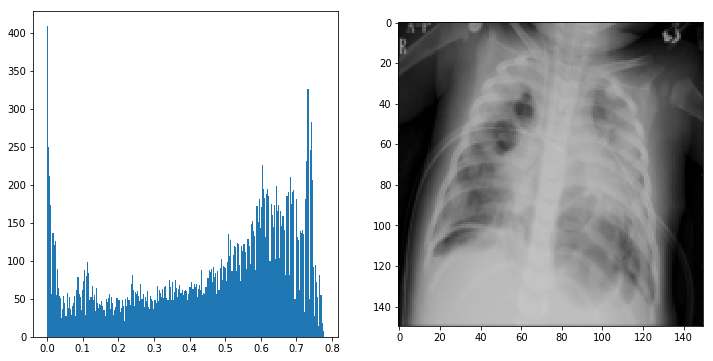

In [3]:

# creo una funcion que grafica
def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.hist(a.ravel(), bins=255)
    plt.subplot(1, 2, 2)
    plt.imshow(a, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
plotHistogram(X_train[3])


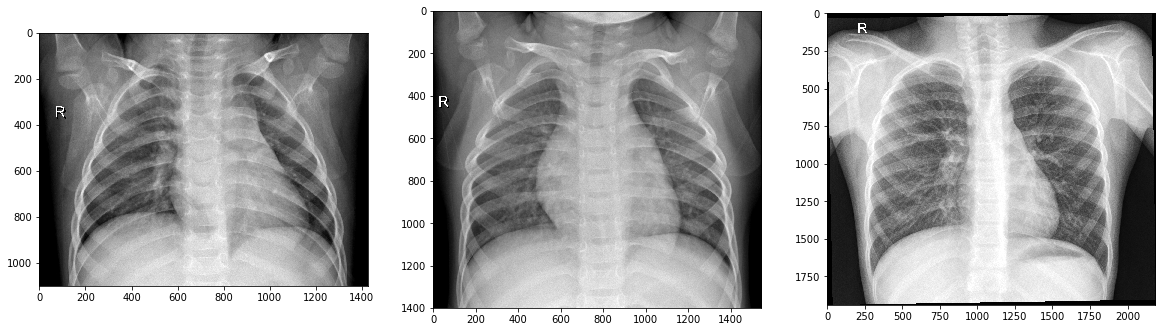

In [4]:
# extraigo varias fotografias de la carpeta de entrenamietno
multipleImages = glob('chest_xray/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

No Neumonía


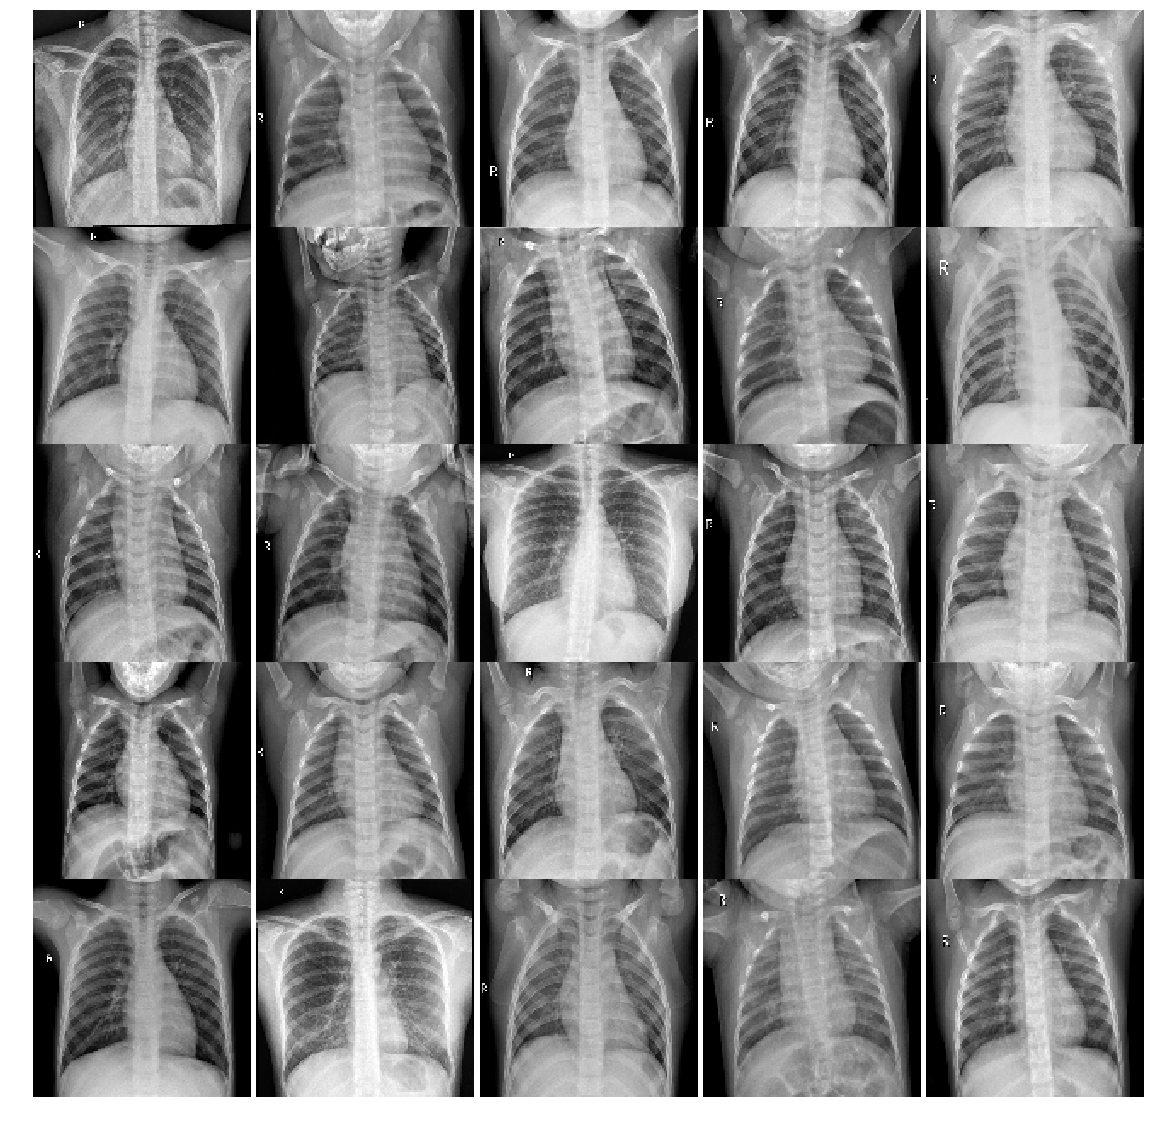

In [5]:
# muestro imagenes de paciente que no padecen neumonia, entrenamiento
print("No Neumonía")
multipleImages = glob('chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Si neumonía


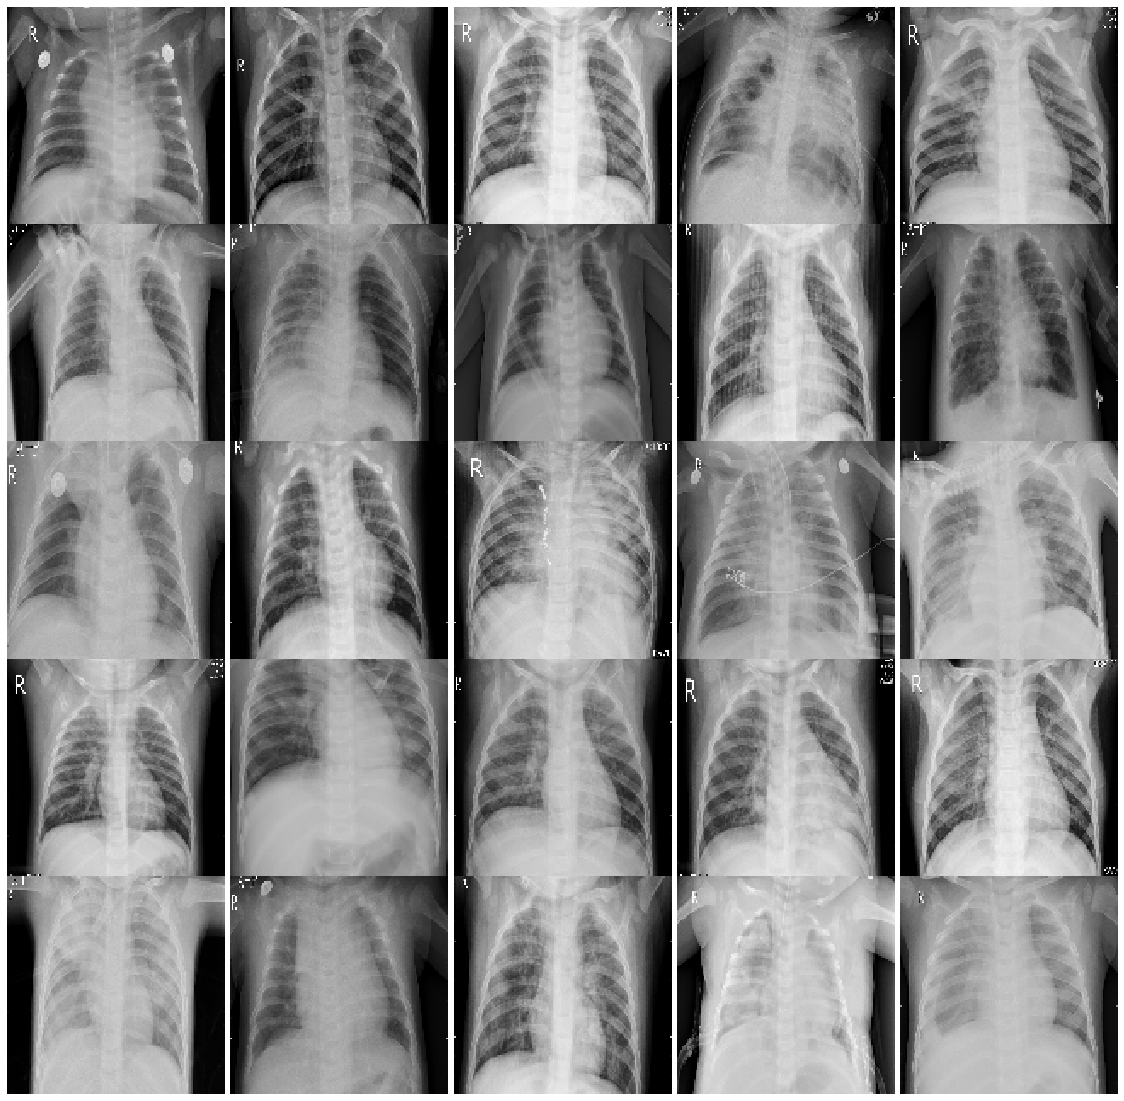

In [4]:
# muestro imagenes de paciente que padecen neumonia, entrenamiento
print("Si neumonía")
multipleImages = glob('chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Neumonía', 1: 'Si Neumonía'}


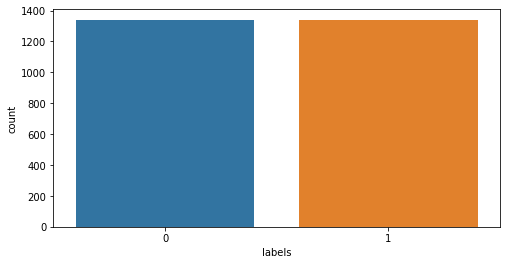

In [5]:
# utilizo la libreria de seaborn para saber si tengo balanceado el data set
import seaborn as sns

plt.figure(figsize=(8,4))
map_characters = {0: 'No Neumonía', 1: 'Si Neumonía'}
dict_characters=map_characters

df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [9]:
"""
X_trainReshaped.shape
y_train
"""


'\nX_trainReshaped.shape\ny_train\n'

In [6]:

#transformo el set de datos en escala de gris 
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)

In [ ]:
# configuro en modelo de redes neuronales
model = models.Sequential()

#invoco la red convulucionales de la libreria keras
# tamaño de la red, tamaño del filtro, funcion de activacion, tamaño la imagen
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
# determino el mapa de caracteristica
model.add(layers.MaxPooling2D((2, 2)))

# capas oculta
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#capa oculta de convolucion
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

#aplano los valores de entrada de la red
model.add(layers.Flatten())
#valores de entrada
model.add(layers.Dense(64, activation='relu'))
# valores de salida
model.add(layers.Dense(2, activation='softmax'))

#model.summary()

In [8]:
# compilo el modelo de red neuronal
model.compile(optimizer='adam', # funcion que optimiza el modelo
              #funcion de perdida o de penalizacion del modelo
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #metrica que deseo optener

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

model.fit(X_trainReshaped, 
          y_train,
          #numero de epocas 
          epochs=20,
          validation_data = (X_testReshaped,y_test),
          callbacks=[tensorboard_callback])

Train on 2682 samples, validate on 624 samples
Epoch 1/20
2682/2682 [==============================] - 60s 22ms/sample - loss: 0.5246 - accuracy: 0.7032 - val_loss: 0.3650 - val_accuracy: 0.8397
Epoch 2/20
2682/2682 [==============================] - 58s 22ms/sample - loss: 0.2018 - accuracy: 0.9206 - val_loss: 0.5149 - val_accuracy: 0.7740
Epoch 3/20
2682/2682 [==============================] - 59s 22ms/sample - loss: 0.1289 - accuracy: 0.9534 - val_loss: 0.4054 - val_accuracy: 0.8670
Epoch 4/20
2682/2682 [==============================] - 57s 21ms/sample - loss: 0.1351 - accuracy: 0.9474 - val_loss: 0.6187 - val_accuracy: 0.8013
Epoch 5/20
2682/2682 [==============================] - 57s 21ms/sample - loss: 0.0997 - accuracy: 0.9601 - val_loss: 0.6546 - val_accuracy: 0.8045
Epoch 6/20
2682/2682 [==============================] - 57s 21ms/sample - loss: 0.0853 - accuracy: 0.9698 - val_loss: 0.6374 - val_accuracy: 0.8349
Epoch 7/20
2682/2682 [==============================] - 59s 22ms/

KeyboardInterrupt: 

In [13]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

624/624 [==============================] - 4s 6ms/sample - loss: 0.9761 - accuracy: 0.7901
0.7900641


In [14]:
test_loss, test_acc = model.evaluate(X_trainReshaped, y_train)

2682/2682 [==============================] - 16s 6ms/sample - loss: 0.0194 - accuracy: 0.9959
